In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = '339'
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
load_directory = os.path.join(dataset_path,F'fly_{fly}/func_0')

In [33]:
brain = {}
for j,ch in enumerate(['red', 'green']):
    print(ch)
    file = os.path.join(load_directory, 'imaging', F'functional_channel_{j+1}.nii')
    data = ants.image_read(file)[:]#[10:-10,3:-3,3:-3,:]
    print(data.shape)
    brain[ch] = data

red
(130, 31, 11, 17588)
green
(130, 31, 11, 17588)


In [31]:
dims = {'x':brain['green'].shape[0],
        'y':brain['green'].shape[1],
        'z':brain['green'].shape[2],
        't':brain['green'].shape[3]}

In [5]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

Trying to load timestamp data from hdf5 file.
Success.


(182788, 25)

In [6]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=5
for behavior,short in zip(behaviors,['R','L','F','T']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

In [7]:
# remove poorly aligned volumes

In [34]:
mean_brain = np.mean(brain['red'],axis=3)
mean_image_flat = mean_brain.flatten()

In [173]:
mean_brain

(130, 31, 11)

In [35]:
raw_red_flat = np.reshape(brain['red'],(-1,dims['t']))

In [36]:
moco_corr = []
for i in range(raw_red_flat.shape[1]):
    moco_corr.append(scipy.stats.pearsonr(mean_image_flat, raw_red_flat[:,i])[0])

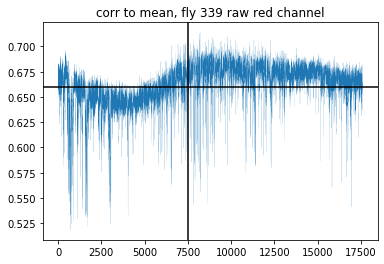

In [43]:
plt.plot(moco_corr,lw=.1)
plt.title('corr to mean, fly 339 raw red channel')
plt.axvline(7500,color='k')
plt.axhline(.66,color='k')

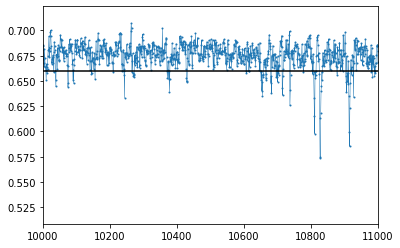

In [42]:
plt.plot(moco_corr,'o',lw=.5,linestyle='-',ms=1)
plt.xlim(10000,11000)
plt.axhline(.66,color='k')

In [46]:
np.argmin(moco_corr[10000:11000])

829

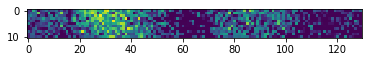

In [51]:
plt.imshow(brain['red'][:,10,:,10000+600].T)

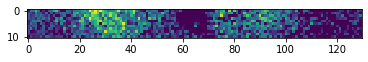

In [52]:
plt.imshow(brain['red'][:,10,:,10000].T)

In [57]:
t_cut = 7500

In [78]:
bad_vols = np.where(np.asarray(moco_corr[t_cut:])<.66)[0]
good_vols = np.where(np.asarray(moco_corr[t_cut:])>=.66)[0]

In [159]:
temp.shape

0.6753311

Text(0.5, 0, 'vol corr to mean')

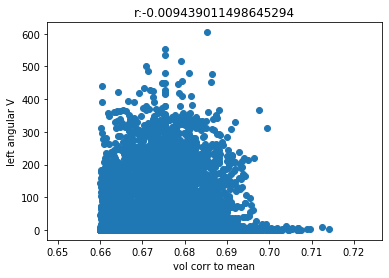

In [172]:
temp = np.asarray(moco_corr[t_cut:])
new_mean_moco_corr = np.mean(temp[good_vols])

temp[bad_vols] = new_mean_moco_corr

plt.scatter(temp,fictrac['L'][t_cut:])
r = scipy.stats.pearsonr(temp,fictrac['L'][t_cut:])[0]
plt.title(F"r:{r}")
plt.ylabel('left angular V')
plt.xlabel('vol corr to mean')

In [165]:
temp = np.asarray(moco_corr[t_cut:])
temp = np.delete(temp, bad_vols)

(10088,)
(8506,)


Text(0.5, 0, 'vol corr to mean')

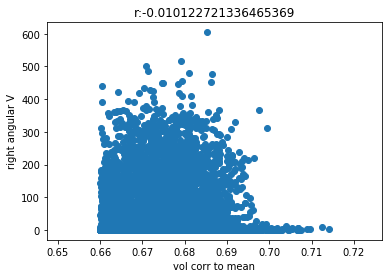

In [170]:
temp = np.asarray(moco_corr[t_cut:])
temp = np.delete(temp, bad_vols)

temp_beh = np.asarray(fictrac['L'][t_cut:])
temp_beh = np.delete(temp_beh, bad_vols)


plt.scatter(temp,temp_beh)
r = scipy.stats.pearsonr(temp,temp_beh)[0]
plt.title(F"r:{r}")
plt.ylabel('right angular V')
plt.xlabel('vol corr to mean')

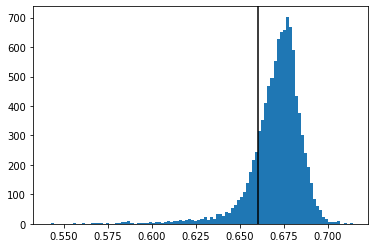

In [167]:
plt.hist(moco_corr[t_cut:],bins=100)
plt.axvline(.66,color='k')

In [169]:
len(bad_vols)

1582

In [79]:
temp = brain['green'][...,t_cut:]
temp = temp[...,good_vols]
meanbrain = np.mean(temp,axis=3)

Text(0.5, 1.0, 'mean green, after t_cut=7500, and good vols')

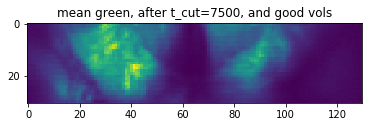

In [80]:
plt.imshow(np.max(meanbrain,axis=2).T)
plt.title('mean green, after t_cut=7500, and good vols')

In [88]:
### replace bad vols with good mean

good_green = brain['green'][...,t_cut:]

for i in bad_vols:
    good_green[...,i] = meanbrain

In [89]:
good_green.shape

(130, 31, 11, 10088)

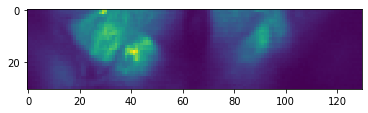

In [100]:
plt.imshow(good_green[:,:,5,829+7500].T)

In [106]:
temp = brain['red'][...,t_cut:]
temp = temp[...,good_vols]
meanbrain = np.mean(temp,axis=3)

### replace bad vols with good mean
good_red = brain['red'][...,t_cut:]
for i in bad_vols:
    good_red[...,i] = meanbrain

In [109]:
good_brain = {}
good_brain['red'] = good_red
good_brain['green'] = good_green

In [101]:
### MAKE CLUSTER DIRECTORY ###
cluster_dir = os.path.join(load_directory, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

### FIT CLUSTERS ###
n_clusters = 400

connectivity = grid_to_graph(dims['x'],dims['y'],dims['z'])
neural_activity = good_green.reshape(-1, good_green.shape[3])
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                            memory=cluster_dir,
                            linkage='ward',
                            connectivity=connectivity)
cluster_model.fit(neural_activity)
cluster_labels = cluster_model.labels_

/home/users/brezovec/.local/lib/python3.6/site-packages/sklearn/cluster/_hierarchical.py:856: UserWarning: Persisting input arguments took 2.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


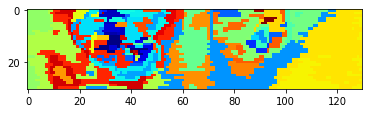

In [102]:
cluster_labels_3d = np.reshape(cluster_labels,(dims['x'],dims['y'],dims['z']))
plt.imshow(cluster_labels_3d[:,:,5].T,cmap='jet')

In [104]:
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

In [111]:
good_brain['red'].shape

(130, 31, 11, 10088)

In [142]:
### GET CLUSTER AVERAGE SIGNAL ###

cluster_activity = {}
filters = {}
corrs={}
for ch in ['green','red']:
    neural_activity = good_brain[ch].reshape(-1, dims['t']-t_cut)
    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    cluster_activity[ch] = np.nan_to_num(np.asarray(signals)).astype('float64')
    print(cluster_activity[ch].shape)
    
    ### GET FILTERS
#     sym_filter = []
#     for cluster_num in range(n_clusters):
#         activity = np.copy(cluster_activity[ch][cluster_num,:])
#         cc_R = scipy.signal.correlate(activity, fictrac['R'][t_cut:])
#         cc_L = scipy.signal.correlate(activity, fictrac['L'][t_cut:])
#         sym_filter.append(cc_R-cc_L)
#     filters[ch] = np.asarray(sym_filter)
    
    ### get correlation at t=0
    corr = []
    for cluster_num in range(n_clusters):
        activity = np.copy(cluster_activity[ch][cluster_num,:])
        cc_R = scipy.stats.pearsonr(activity, fictrac['R'][t_cut:])[0]
        cc_L = scipy.stats.pearsonr(activity, fictrac['L'][t_cut:])[0]
        corr.append(cc_R)
    corrs[ch] = np.asarray(corr)

(400, 10088)
(400, 10088)


In [145]:
np.max(corrs['green'])

0.30574965814917077

In [127]:
np.mean(fictrac['R'][t_cut:])

48.07544993755418

In [128]:
np.mean(fictrac['L'][t_cut:])

38.38521748279817

In [74]:
cluster_num = 106
neural_activity = brain['green'].reshape(-1, dims['t'])
cluster_indicies = np.where(cluster_labels==cluster_num)[0]
mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)

cc_R = scipy.signal.correlate(mean_signal, fictrac['R'])
cc_L = scipy.signal.correlate(mean_signal, fictrac['L'])

(10000, 11000)

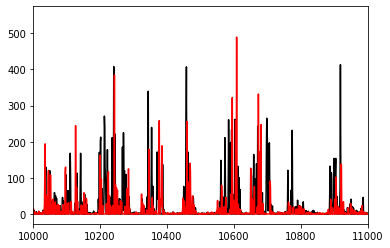

In [79]:
plt.plot(fictrac['R'],color='k')
plt.plot(fictrac['L'],color='r')
plt.xlim(10000,11000)

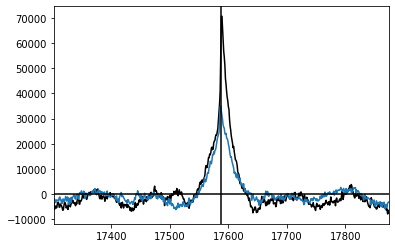

In [76]:
plt.plot(cc_R,color='k')
plt.plot(cc_L)
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')

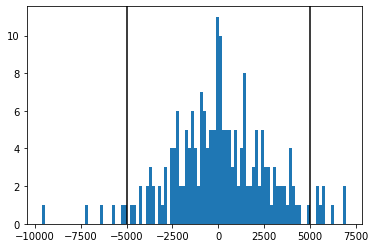

In [65]:
low_cutoff = -5000
high_cutoff = 5000

plt.hist(filters['red'][:,17588],bins=100);
plt.axvline(low_cutoff,color='k')
plt.axvline(high_cutoff,color='k')



In [66]:
bad_red_clusters = np.concatenate((np.where(filters['red'][:,17588]<low_cutoff)[0],
               np.where(filters['red'][:,17588]>high_cutoff)[0]))

In [152]:
np.argmin(filters['red'][:,17588])

157

In [245]:
empty = np.zeros(cluster_labels.shape)
for cluster_num in [137]:#range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    empty[cluster_indicies] = 1
empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

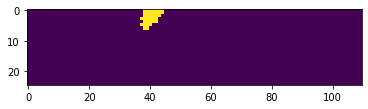

In [249]:
plt.imshow(empty[:,:,3].T)

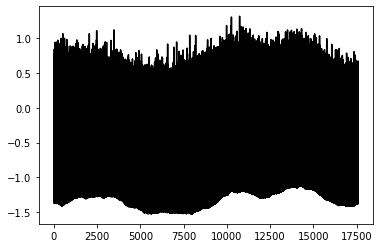

In [120]:
cluster_num = 141

plt.plot(cluster_activity['red'][cluster_num,:],'k')
activity = np.copy(cluster_activity['red'][cluster_num,:])
activity[bad_moco] = 0

plt.plot(activity,'r')

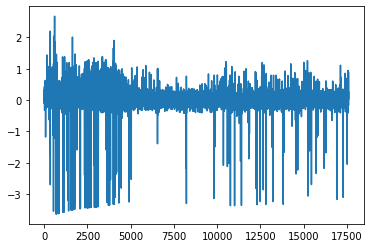

In [54]:
activity = np.copy(cluster_activity[ch][cluster_num,:])
activity[bad_moco] = 0
plt.plot(activity)

In [53]:
activity = cluster_activity[ch][cluster_num,:]
activity[14086]

-0.012866327539086342

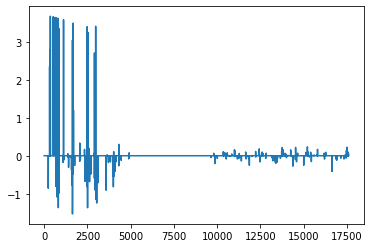

In [55]:
plt.plot(activity-cluster_activity[ch][cluster_num,:])

In [115]:
filters['red'].shape

(400, 35175)

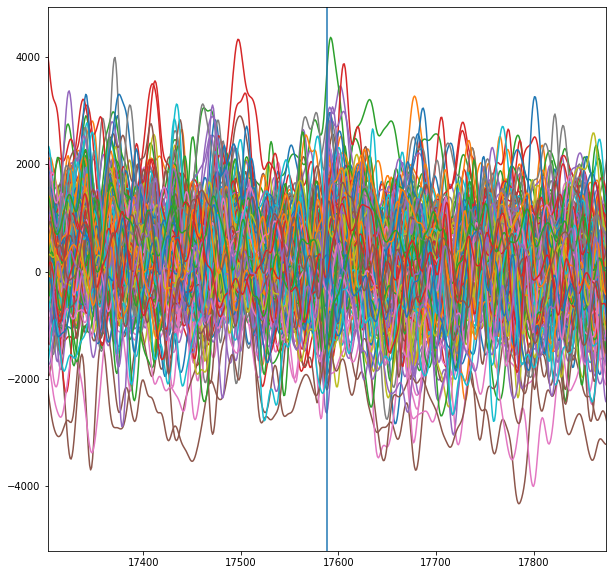

In [67]:
ch = 'red'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    if cluster_num in bad_red_clusters:
        continue
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    plt.plot(smo)
    clusters.append(cluster_num)
    cnt+=1

#plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [184]:
filters[ch][:,:].shape

(200, 35175)

In [ ]:
plt.hist(filters[ch][cluster_num,:])

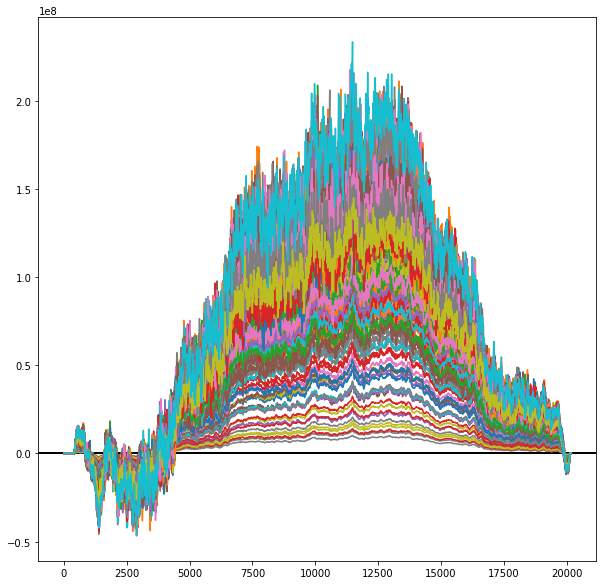

In [126]:
ch = 'green'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    #if cluster_num in bad_red_clusters:
    #    continue
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    plt.plot(smo)
    clusters.append(cluster_num)
    cnt+=1

#plt.xlim(dims['t']-window_30s-t_cut-400,dims['t']+window_30s-t_cut+400)
#plt.axvline(dims['t']-t_cut)

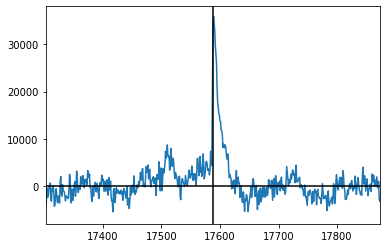

In [70]:
plt.plot(filters['green'][106,:])
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')

In [244]:
bad_red_clusters

array([ 41,  94, 124, 157, 167, 106, 120, 134, 151, 168, 187])

In [243]:
np.argsort(filters['green'][:,17588])

array([157, 137, 197,  41, 167, 126,  60, 168, 186,  15,  79,  45, 181,
        81,  44,  73,  62, 124,  66,  61, 172, 136,  28, 196, 156,  56,
       194, 150,  80, 129, 104,  31, 149, 141,  82,  18, 169,  11,   6,
        71,   3,  46, 177, 132,  33,  97, 160, 193, 110,  89, 135,  59,
        38,  92,  21,  12,  93, 148, 111,  70,   1,  83, 116, 142, 131,
        57,  76,   2, 182,  49, 112,  19, 147, 171,  55,  13,  42, 173,
        95, 198,  94,  90, 138,  10,  53,  86, 176, 192, 139, 107,  67,
        36,  32,  74,  27,  77, 185,  88, 191, 109,  40,  34, 179,  22,
         4, 130,  47,  48, 180, 105,  37,  65, 189, 183,  14,   5,  87,
        58,  29,  35, 121,  84,   0,  26, 118, 199, 175,  51,   7, 143,
       163,   9, 154, 103, 159, 195, 102, 165,  72, 127,  43,  16,  39,
       155, 125, 144,  64,  30,  85,  98,  63,  25, 166, 100, 190, 123,
       146,  91,  96, 161,  17, 164,  54,  20, 158,  50, 119, 152, 170,
       145, 108,  69, 113,   8,  78,  68, 114, 188, 153, 115, 12

In [123]:
filters['green'].shape

(400, 20175)

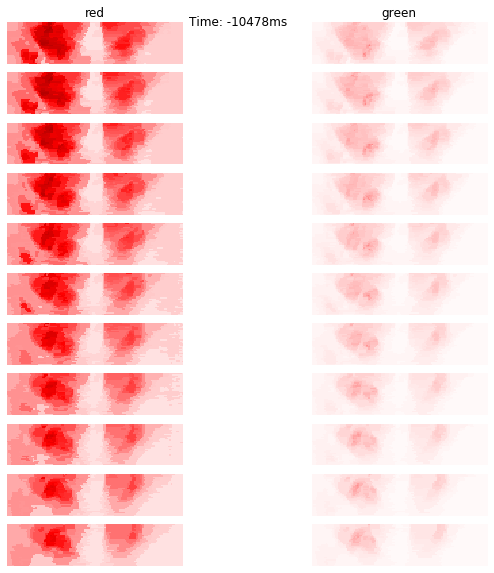

In [122]:
plt.figure(figsize=(10,10))

t=-100

for ch in ['red','green']:
    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        #if cluster_num not in bad_red_clusters:
        empty[cluster_indicies] = filters[ch][cluster_num,dims['t']+t-t_cut]
        #else:
        #    empty[cluster_indicies] = 0
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    for z in range(dims['z']):
        if ch == 'red':
            plt.subplot(dims['z'],2,z*2+1)
            if z == 0:
                plt.title('red')
        else:
            plt.subplot(dims['z'],2,z*2+2)
            if z == 0:
                plt.title('green')
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=800000000,vmin=-800000000)
        plt.axis('off')
        
        
        
    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)

In [132]:
corrs['green'][0]

-0.0022171769692662727

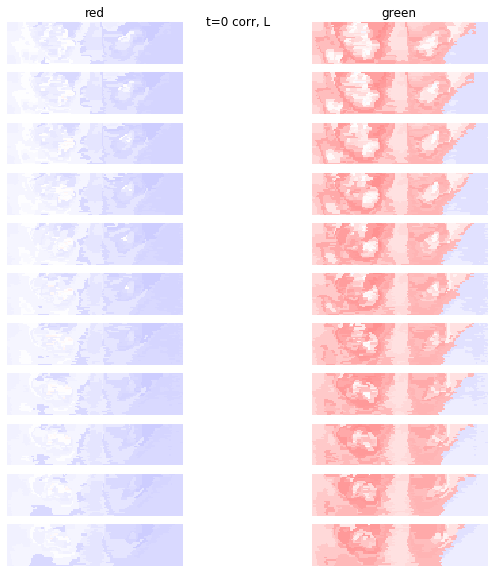

In [141]:
plt.figure(figsize=(10,10))


for ch in ['red','green']:
    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        #if cluster_num not in bad_red_clusters:
        empty[cluster_indicies] = corrs[ch][cluster_num]
        #else:
        #    empty[cluster_indicies] = 0
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    for z in range(dims['z']):
        if ch == 'red':
            plt.subplot(dims['z'],2,z*2+1)
            if z == 0:
                plt.title('red')
        else:
            plt.subplot(dims['z'],2,z*2+2)
            if z == 0:
                plt.title('green')
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=1,vmin=-1)
        plt.axis('off')
        
    plt.suptitle("t=0 corr, L",y=.89)

In [227]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20240205_movie_339'
os.mkdir(save_path)

In [228]:
plt.figure(figsize=(10,10))


for k,t in tqdm.tqdm(enumerate(np.arange(-140,2,2))):

    for ch in ['red','green']:
        empty = np.zeros(cluster_labels.shape)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels==cluster_num)[0]
            if cluster_num not in bad_red_clusters:
                empty[cluster_indicies] = filters[ch][cluster_num,dims['t']+t]
            else:
                empty[cluster_indicies] = 0
        empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

        for z in range(dims['z']):
            if ch == 'red':
                plt.subplot(dims['z'],2,z*2+1)
                if z == 0:
                    plt.title('red')
            else:
                plt.subplot(dims['z'],2,z*2+2)
                if z == 0:
                    plt.title('green')
            plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=80000,vmin=-80000)
            plt.axis('off')

    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()

71it [00:34,  2.08it/s]


<Figure size 720x720 with 0 Axes>

In [154]:
for k,t in tqdm.tqdm(enumerate(np.arange(-140,2,2))):

    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        empty[cluster_indicies] = sym_filter[cluster_num,dims['t']+t]
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    plt.figure(figsize=(10,20))
    for z in range(dims['z']):
        plt.subplot(dims['z'],1,z+1)
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=10000,vmin=-10000)
        plt.axis('off')
    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()

20it [00:12,  1.54it/s]/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
71it [00:45,  1.57it/s]


<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

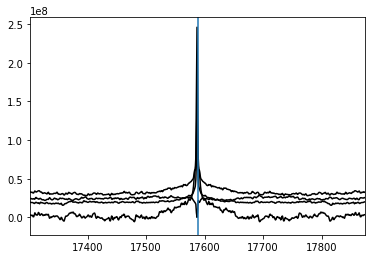

In [255]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['T'], fictrac['T'])
plt.plot(cc,color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])